In [2]:
import matplotlib    # 数据图可视化

# 解决图中中文和负号无法显示的问题
# matplotlib.rcParams['配置参数']=[修改值]修改画图配置，rcParams即run configuration parameters运行配置参数。
matplotlib.rcParams['font.sans-serif']=[u'simHei']
matplotlib.rcParams['axes.unicode_minus']=False    # minus--正负号

In [3]:
'''
pandas是基于numpy数组构建的，但二者最大的不同是pandas是专门为处理表格和混杂数据设计的，比较契合统计分析中的表结构，
而numpy更适合处理统一的数值数组数据。pandas数组结构有一维Series和二维DataFrame。
''' 
# Series是一种类似于一维数组的对象，它由一组数据以及一组与之相关的数据标签（索引index）组成。
# Series的字符串表现形式为：索引在左边，值在右边。如果不为数据指定索引，则会默认创建一个0到n-1的整数型索引。 
# DataFrame是一个表格型的数据结构
import pandas as pd

# numpy是以矩阵为基础的数学计算模块，提供高性能的矩阵运算，数组结构为ndarray，只能存储一种类型的数据。 
import numpy as np

In [4]:
'''
TF-IDF: 如果某个词或短语在一篇文章中出现的频率TF高，并且在其他文章中很少出现，则认为此词或者短语具有很好的类别区分能力，适合用来分类。
1. TF(Term Frequency)：表示词汇频率，对词数（Term Count）的归一化。
--如果一个词条在一个类的文档中频繁出现，则说明该词条能够很好代表这个类的文本的特征，这样的词条应该给它们赋予较高的权重，并选来作为该类文本的
特征词以区别与其它类文档。这种搜索词加权可归纳为：文档中出现的搜索词的权重与搜索词频率成正比。
--缺点：不能有效的过滤中止词，例如the，1，2等。
2. IDF(Inverse document frequency)：表示逆向文档频率。IDF是一个词语普遍重要性的度量(过滤中止词)。
--降低中止词权重，给其它术语足够的权重。这种加权可以归纳为：词语的特异性可以量化为其出现的文档数量的反函数。
3. TF-IDF是两个统计量的乘积。
'''
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model.logistic import LogisticRegression
# cross_val_score交叉验证
from sklearn.model_selection import train_test_split, cross_val_score

In [5]:
# header: 是否保存列名，默认为 True ，保存
'''
csv文件默认的是以逗号为分隔符，使用 delimiter="\t" 将tab作为分割符.因为 read.csv 默认分隔符是“,”，比如前面都是一行没有“，”，
后面突然出现一行有“，”，这时这行数据就会变成两列，前面是一列，后面忽然变成两列，
这时程序就会报错：ParserError: Error tokenizing data. C error: Expected 1 fields in line 29, saw 2
'''
df = pd.read_csv('SMSSpamCollection.csv', header=None, delimiter="\t")  

# df.head()会将表格中的第一行看作列名, df.head(5)输出前5行，df.head输出所有行
print(df.head(5))
print(df.shape)

      0                                                  1
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
(5572, 2)


In [6]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [7]:
print("垃圾邮件个数：%s" % df[df[0]=='spam'][0].count())
print("正常邮件个数：%s" % df[df[0]=='ham'][0].count())

垃圾邮件个数：747
正常邮件个数：4825


- fit和transform没有任何关系，仅仅是数据处理的两个不同环节，之所以出来fit_transform这个函数名，仅仅是为了写代码方便，会高效一点。


- sklearn里的封装好的各种算法使用前都要fit，fit相对于整个代码而言，为后续API服务。fit之后，然后调用各种API方法，transform只是其中一个API方法，所以当你调用transform之外的方法，也必须要先fit。


- fit原义指的是安装、使适合的意思，其实有点train的含义，但是和train不同的是，它并不是一个训练的过程，而是一个适配的过程，过程都是确定的，最后得到一个可用于转换的有价值的信息。


1. 数据预处理中方法

    fit(): Method calculates the parameters μ and σ and saves them as internal objects.
    解释：简单来说，就是求得训练集X的均值，方差，最大值，最小值,这些训练集X固有的属性。

    transform(): Method using these calculated parameters apply the transformation to a particular dataset.
    解释：在fit的基础上，进行标准化，降维，归一化等操作（看具体用的是哪个工具，如PCA，StandardScaler等）。

    fit_transform(): joins the fit() and transform() method for transformation of dataset.
    解释：fit_transform是fit和transform的组合，既包括了训练又包含了转换。
    transform()和fit_transform()二者的功能都是对数据进行某种统一处理（比如标准化~N(0,1)，将数据缩放(映射)到某个固定区间，归一化，正则化等）

    fit_transform(trainData)对部分数据先拟合fit，找到该part的整体指标，如均值、方差、最大值最小值等等（根据具体转换的目的），然后对该trainData进行转换transform，从而实现数据的标准化、归一化等等。

In [8]:
# 采用DataFrame.values属性以返回给定DataFrame的numpy表示形式
X = df[1].values
y = df[0].values

# 切割数据集，训练集：测试集 = 8：2
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2)
print(y_test.shape)
# 创建TfidfVectorizer实例，将训练文本和测试文本都进行转换
# 特征提取
# TfidfVectorizer()为文本特征提取函数，将文本转换成特征向量
vectorizer = TfidfVectorizer()

X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)

(1115,)


In [9]:
# 建立逻辑回归模型训练和预测
LR = LogisticRegression()
LR.fit(X_train, y_train)

predictions = LR.predict(X_test)
print(predictions[:5])

for i,prediction in enumerate(predictions[:5]):
    print("预测为 %s ,信件为 %s" % (prediction,X_test_raw[i]))

['ham' 'ham' 'ham' 'ham' 'ham']
预测为 ham ,信件为 Yep, by the pretty sculpture
预测为 ham ,信件为 Orh i tot u say she now still dun believe.
预测为 ham ,信件为 Come by our room at some point so we can iron out the plan for this weekend
预测为 ham ,信件为 Somewhr someone is surely made 4 u. And God has decided a perfect time to make u meet dat person. . . . till den, . . . . . Enjoy ur crushes..!!!;-)
预测为 ham ,信件为 Jus finish bathing...


In [10]:
# 二元分类性能指标：混淆矩阵
# 混淆矩阵的对角线值越高越好，表明许多正确的预测。
# 列代表预测的类别；行代表实际的类别。对角线上的值表示预测正确的数量/比例；非对角线元素是预测错误的部分。
from sklearn.metrics import confusion_matrix
# predictions 与 y_test
confusion_matrix = confusion_matrix(y_test, predictions)
print(confusion_matrix)

[[977   2]
 [ 30 106]]


In [11]:
import matplotlib.pyplot as plt
plt.matshow(confusion_matrix)    # plt.matshow()把矩阵或者数组绘制成图像
plt.title("混淆矩阵")
plt.colorbar()
plt.ylabel("真实值")
plt.xlabel("预测值")
plt.show()

<Figure size 480x480 with 2 Axes>

In [12]:
# 给出 precision    recall  f1-score   support
'''
1. precision ( 精确度)：正确预测为正的，占全部预测为正的比例。precision = TP/(TP+FP)
2. recall（召回率）：正确预测为正的，占全部实际为正的比例。recall = TP/(TP+FN)
3. F1-score (F1值)：精确率和召回率的调和平均数。F1 Score = 2*(precision * recall) / (precision + recall)
4. support （各分类样本的数量或测试集样本的总数量）。
5. avg/total 是每一分类占总数的比例加权算出来的。
'''
'''
1. precision即准确度，也是衡量分类器能正确识别样本的能力，它表示的是，在被识别成正样本的样本中，正确预测的样本占的比例，
通常叫做查准率。recall即召回率，它表示的是，被预测的所有正样本，能够被正确预测的占比，通常叫查全率。
2. F1-score认为召回率和精确率同等重要，是精确率和召回率的调和平均数，最大为1，最小为0。
'''
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

        ham       0.97      1.00      0.98       979
       spam       0.98      0.78      0.87       136

avg / total       0.97      0.97      0.97      1115



In [13]:
from sklearn.metrics import roc_curve, auc
# 准确率
'''
sklearn.model_selection.cross_val_score(estimator, X, y=None, 
cv=None, n_jobs=1, verbose=0, fit_params=None, pre_dispatch=‘2*n_jobs’)

estimator:估计方法对象(分类器)
X：数据特征(Features)
y：数据标签(Labels)
cv：几折交叉验证
n_jobs：同时工作的cpu个数（-1代表全部）
'''
scores =  cross_val_score(LR, X_train, y_train, cv=5)
print("准确率为: ",scores)
print("平均准确率为: ",np.mean(scores))

准确率为:  [0.96640538 0.96071829 0.96184063 0.94837262 0.95061728]
平均准确率为:  0.9575908393377597


In [14]:
# 有时必须要将标签转为数值
from sklearn.preprocessing import LabelEncoder    # 将n个类别编码为 0~n-1 之间的整数（包含0和n-1）。
# 初始化
class_le = LabelEncoder()
# fit 训练 LabelEncoder, 把 ham 编码为 0，spam 编码为 1
# transform 使用训练好的 LabelEncoder 对原数据进行编码
y_train_n = class_le.fit_transform(y_train)
y_test_n = class_le.fit_transform(y_test)

In [15]:
# 精准率
precision =  cross_val_score(LR, X_train, y_train_n, cv=5, scoring='precision')
print("平均精准率为: ",np.mean(precision))

# 召回率
recall =  cross_val_score(LR, X_train, y_train_n, cv=5,scoring='recall')
print("平均召回率为: ",np.mean(recall))   

# F1值
f1 =  cross_val_score(LR, X_train, y_train_n, cv=5, scoring='f1')
print("平均F1值为: ",np.mean(f1))  

平均精准率为:  0.9930402930402931
平均召回率为:  0.6954818072770892
平均F1值为:  0.8169774200760116


In [20]:
# 画出ROC曲线，AUV为ROC曲线以下部分的面积
# In[4] ROC曲线 y_test_n为数值
'''
predict返回的是一个预测的值，predict_proba返回的是对于预测为各个类别的概率。predict_proba返回的是一个 n 行 k 列的数组，
第 i 行 j列的数值是模型预测 第 i 个预测样本为某个标签的概率，并且每一行的概率和为1。
'''
predictions_pro = LR.predict_proba(X_test)    # 第0列为标签‘0’，第1列为标签‘1’
print("predictions_pro为：", predictions_pro)    

predictions_pro为： [[0.93552378 0.06447622]
 [0.94885667 0.05114333]
 [0.96162717 0.03837283]
 ...
 [0.96629684 0.03370316]
 [0.98322969 0.01677031]
 [0.95063804 0.04936196]]


In [28]:
'''
roc_curve() 函数有3个返回值：

    fpr：False positive rate。
    tpr：True positive rate。
    thresholds: 每个阈值对应一个 fpr 和 tpr。
'''
# y_test_n: 真实的样本标签； predictions_pro[:, 1]: 样本预测结果。
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_n, predictions_pro[:, 1])

- score为真实标签
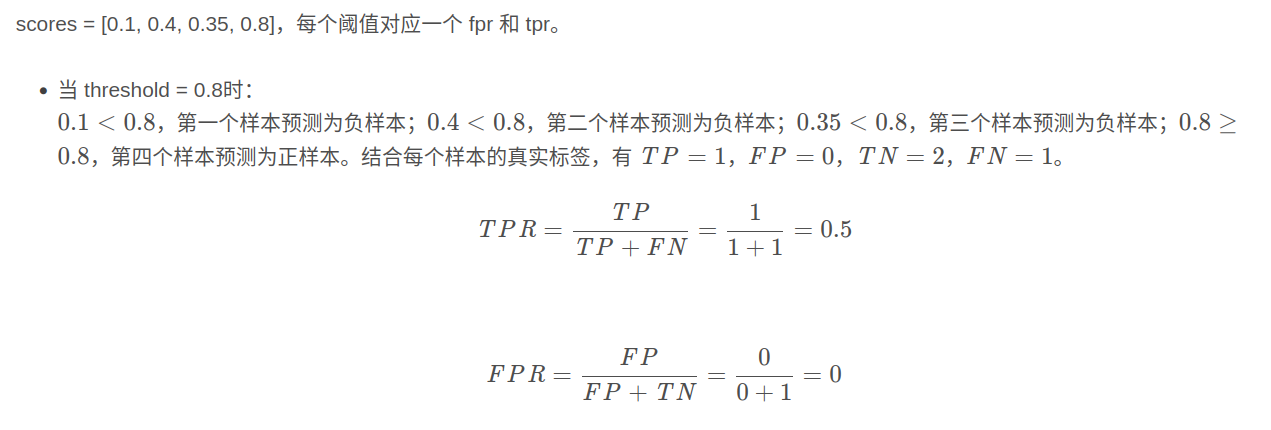

In [ ]:
'''
AUC为ROC曲线下方的面积，显然这个面积的数值不会大于1。又由于ROC曲线一般都处于y=x这条直线的上方，所以AUC的取值范围在0.5和1之间。
AUC越接近1.0，检测方法真实性越高;等于0.5时，则真实性最低，无应用价值。
'''
roc_auc = auc(false_positive_rate, true_positive_rate)

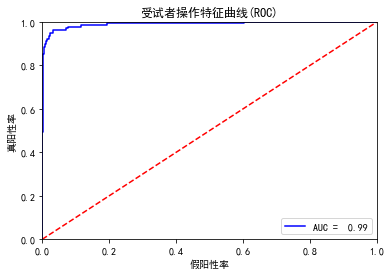

In [31]:
plt.title("受试者操作特征曲线(ROC)")    # ROC曲线越靠近左上角，分类效果越好
plt.plot(false_positive_rate, true_positive_rate, 'b', label='AUC = % 0.2f' % roc_auc)

plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')    # plt.plot(x,y), x为x轴数据，y为y轴数据
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.show()